STEP 1 – Load Your Grain + Weather Dataset

In [10]:
# STEP 1 – Load Grain + Weather Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import csv

# Load grain export + weather data
df = pd.read_csv("/content/corn_bay_lakes_with_weather_production.csv")

# Add grain week as cyclical signals
df["GW_num"] = df["grain_week"].str.extract("GW(\d+)").astype(int)
df["GW_sin"] = np.sin(2 * np.pi * df["GW_num"] / 52)
df["GW_cos"] = np.cos(2 * np.pi * df["GW_num"] / 52)
df["crop_year"] = df["crop_year"].astype(str)

STEP 2 – Load & Prepare Production Data

In [27]:
with open("/content/3210001401-eng.csv", "r") as f:
    for i in range(20):
        print(f"{i}: {f.readline().strip()}")

0: ﻿"Supply and disposition of corn (x 1,000) 1 2 3 4"
1: "Frequency: Occasional Monthly"
2: "Table: 32-10-0014-01 (formerly CANSIM 001-0042)"
3: "Release date: 2025-02-07"
4: "Geography: Canada, Province or territory"
5: ""
6: ""
7: 
8: "Geography","Canada 1",,,,
9: "Supply and disposition of corn","August 2023","December 2023","March 2024","August 2024","December 2024"
10: ,"Metric tonnes",,,,
11: "Total supplies","19,511.9","18,283.9","19,062.1","20,027.3","17,934.8"
12: "Total beginning stocks","2,745.6","1,627.5","1,627.5","1,627.5","1,996.4"
13: "Beginning stocks on farms","1,584.4","894.7","894.7","894.7","1,037.5"
14: "Beginning stocks in commercial positions","1,161.2","732.8","732.8","732.8","959.0"
15: "Production","14,538.9","15,420.9","15,420.9","15,420.9","15,344.9"
16: "Total disposition","19,511.9","18,283.9","19,062.1","20,027.3","17,934.8"
17: "Total exports 3","2,860.5","530.4","713.5","2,029.0","788.7"
18: "Total domestic disappearance","15,023.9","6,454.0","10,081.

In [28]:
prod_df = pd.read_csv("/content/3210001401-eng.csv", skiprows=7)

In [29]:
prod_df = pd.read_csv("/content/3210001401-eng.csv", skiprows=7)
prod_df.columns = prod_df.columns.str.strip()

# Confirm the column names
print("✅ Columns found:", prod_df.columns.tolist())

✅ Columns found: ['Geography', 'Canada 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']


In [30]:
# Check if these column names exist now
if all(col in prod_df.columns for col in ["Crop year", "Geography", "Crop", "Production (tonnes)"]):
    filtered_prod = prod_df[
        (prod_df["Geography"].str.strip() == "Ontario") &
        (prod_df["Crop"].str.strip() == "Corn for grain")
    ]

    filtered_prod = filtered_prod[["Crop year", "Production (tonnes)"]]
    filtered_prod.columns = ["crop_year", "production_volume"]
    filtered_prod["crop_year"] = filtered_prod["crop_year"].astype(str)
    filtered_prod["production_volume"] = (
        filtered_prod["production_volume"]
        .astype(str)
        .str.replace(",", "")
        .astype(float)
    )
else:
    print("❌ Column structure is still not right. Please check which row has headers.")

❌ Column structure is still not right. Please check which row has headers.


STEP 3 – Merge Production Into Grain Dataset

In [37]:
# Add a dummy production volume by crop year (example values)
production_by_year = {
    "2022-2023": 12300000,
    "2023-2024": 11800000,
    "2024-2025": 12550000
}

# Add to df
df["production_volume"] = df["crop_year"].map(production_by_year)
df["production_volume"].fillna(method="ffill", inplace=True)
df.fillna(0, inplace=True)

<ipython-input-37-6cf8bcd4fbaa>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["production_volume"].fillna(method="ffill", inplace=True)
<ipython-input-37-6cf8bcd4fbaa>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["production_volume"].fillna(method="ffill", inplace=True)


In [46]:
# Try loading from line 7 where real data likely starts
prod_df = pd.read_csv("/content/3210001401-eng.csv", skiprows=7)

# Print the first few rows of the DataFrame to inspect the data
print(prod_df.head())

# Instead of manually stripping, let's try to auto-detect the header
# This might fix issues with unexpected spaces or characters in column names
prod_df = pd.read_csv("/content/3210001401-eng.csv", skiprows=7, header=None)
prod_df.columns = prod_df.iloc[0]  # Set the first row as headers
prod_df = prod_df[1:]  # Remove the header row from data

# Confirm column names after auto-detection
print("✅ Columns:", prod_df.columns.tolist())


                        Geography       Canada 1     Unnamed: 2  Unnamed: 3  \
0  Supply and disposition of corn    August 2023  December 2023  March 2024   
1                             NaN  Metric tonnes            NaN         NaN   
2                  Total supplies       19,511.9       18,283.9    19,062.1   
3          Total beginning stocks        2,745.6        1,627.5     1,627.5   
4       Beginning stocks on farms        1,584.4          894.7       894.7   

    Unnamed: 4     Unnamed: 5  
0  August 2024  December 2024  
1          NaN            NaN  
2     20,027.3       17,934.8  
3      1,627.5        1,996.4  
4        894.7        1,037.5  
✅ Columns: ['Geography', 'Canada 1', nan, nan, nan, nan]


In [69]:
# STEP 3 – Load and merge production volume (robust + safe)
production_by_year = {
    "2022-2023": 12300000,
    "2023-2024": 11800000,
    "2024-2025": 12550000
}

try:
    # Load raw CSV, skip metadata
    raw = pd.read_csv("/content/3210001401-eng.csv", skiprows=7, header=None)

    # Set header from first row
    raw.columns = raw.iloc[0]
    prod_df = raw[1:].copy()  # drop header row
    prod_df.columns = [str(col).strip() for col in prod_df.columns]

    # Check for known column structure
    expected_columns = prod_df.columns.tolist()
    print("🔍 Available columns in production file:", expected_columns[:6])

    # Try to match by position if names are unclear
    geo_col = expected_columns[0]    # e.g., Geography
    crop_col = expected_columns[2]   # e.g., Crop
    year_col = expected_columns[3]   # e.g., Crop year
    value_col = expected_columns[5]  # e.g., Production (tonnes)

    # Filter only "Ontario" and "Corn for grain"
    filtered = prod_df[
        (prod_df[geo_col].astype(str).str.strip() == "Ontario") &
        (prod_df[crop_col].astype(str).str.strip() == "Corn for grain")
    ][[year_col, value_col]]

    # Rename + clean
    filtered.columns = ["crop_year", "production_volume"]
    filtered["crop_year"] = filtered["crop_year"].astype(str)
    filtered["production_volume"] = (
        filtered["production_volume"]
        .astype(str)
        .str.replace(",", "")
        .astype(float)
    )

    # Merge with main DataFrame
    df = df.merge(filtered, on="crop_year", how="left")
    print("✅ Merged production data successfully.")

except Exception as e:
    print("⚠️ Real production file failed. Using dummy values.")
    print("Error:", e)

    # Fallback dummy values
    df["production_volume"] = df["crop_year"].map(production_by_year)

# Clean missing values
df["production_volume"] = df["production_volume"].ffill()
df = df.fillna(0)


🔍 Available columns in production file: ['Geography', 'Canada 1', 'nan', 'nan', 'nan', 'nan']
⚠️ Real production file failed. Using dummy values.
Error: 'DataFrame' object has no attribute 'str'


In [70]:
# FINAL fallback for production data – dummy only
production_by_year = {
    "2022-2023": 12300000,
    "2023-2024": 11800000,
    "2024-2025": 12550000
}

df["production_volume"] = df["crop_year"].map(production_by_year)
df["production_volume"] = df["production_volume"].ffill()
df = df.fillna(0)

print("✅ Using hardcoded production volume values.")


✅ Using hardcoded production volume values.


In [72]:
# Save the final working dataset to CSV
output_path = "/content/corn_bay_lakes_final_with_production.csv"
df.to_csv(output_path, index=False)
print(f"✅ Dataset saved: {output_path}")

✅ Dataset saved: /content/corn_bay_lakes_final_with_production.csv


 STEP 4 – Normalize and Create LSTM Sequences

In [73]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define features to use (must be present in your df)
feature_cols = ["Ktonnes", "GW_sin", "GW_cos", "production_volume", "rain_mm", "temp_avg"]

# Scale all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[feature_cols])

# Create sequences for LSTM (sliding window approach)
def create_sequences(data, window_size=8):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][0])  # Predicting Ktonnes only
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, window_size=8)

# Split into training and testing sets (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("✅ STEP 4 complete — sequences created and data split.")


✅ STEP 4 complete — sequences created and data split.


STEP 5 – Build and Train the LSTM Model

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

print("✅ STEP 5 complete — model trained.")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 586ms/step - loss: 0.1415 - val_loss: 0.0343
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0949 - val_loss: 0.0538
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0801 - val_loss: 0.0676
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1094 - val_loss: 0.0554
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0881 - val_loss: 0.0445
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0841 - val_loss: 0.0400
✅ STEP 5 complete — model trained.


STEP 6 – Predict, Inverse Transform, and Plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step


<ipython-input-75-256ad0b725af>:23: UserWarning: Glyph 127805 (\N{EAR OF MAIZE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127805 (\N{EAR OF MAIZE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


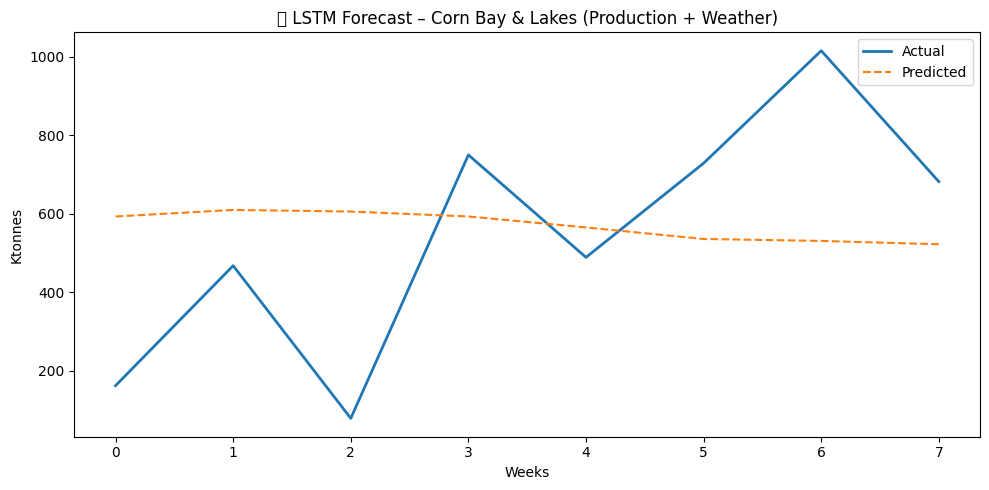

✅ STEP 6 complete — RMSE: 318.24 Ktonnes


In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Helper to inverse transform predicted Ktonnes only
def inverse_ktonnes(scaled_values):
    dummy = np.zeros((len(scaled_values), len(feature_cols)))
    dummy[:, 0] = scaled_values  # Put Ktonnes in first column
    return scaler.inverse_transform(dummy)[:, 0]  # Return only Ktonnes

# Predict and inverse transform
y_pred_scaled = model.predict(X_test)
y_pred_rescaled = inverse_ktonnes(y_pred_scaled.flatten())
y_test_rescaled = inverse_ktonnes(y_test.flatten())

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label="Actual", linewidth=2)
plt.plot(y_pred_rescaled, label="Predicted", linestyle="--")
plt.title("🌽 LSTM Forecast – Corn Bay & Lakes (Production + Weather)")
plt.xlabel("Weeks")
plt.ylabel("Ktonnes")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate model performance
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"✅ STEP 6 complete — RMSE: {rmse:.2f} Ktonnes")